# Classification Algorithm:

- Data Description.

- Goal.
    
Using logistic regression to understand the demographics and other characteristics of a bank customers' that accept a credit card offer and that do not accept a credit card.

Data cleaning, wrangling and EDA on a database relative to an automobile portfolio from an insurance company. The goal is to analyze the data and define a model that fits to do predictions. The the variable 'total claim amount' should be considered as a target.

## 1. Importing used packages

In [1]:
import pymysql
from sqlalchemy import create_engine
from scipy import stats
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
import getpass
password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/mid_project'
engine = create_engine(connection_string)

import warnings
warnings.filterwarnings('ignore')

········


## 2. Getting Data

In [2]:
query = '''SELECT *
           FROM creditcardmarketing
           ;'''

data = pd.read_sql_query(query, engine)
data

,ï»¿Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095,1002
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78,366
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145,242
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119,419
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,17996,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50,136,65,71,398
17972,17997,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,984,940,943,535
17973,17998,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,918,767,1170,1494
17974,17999,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,1022.25,626,983,865,1615


## 3. Cleaning/Wrangling/EDA

- Change headers names.
- Deal with NaN values.
- Categorical Features.
- Numerical Features.
- Exploration.

In [3]:
data.shape, data.dtypes

((17976, 17),
 ï»¿Customer Number        int64
 Offer Accepted           object
 Reward                   object
 Mailer Type              object
 Income Level             object
 # Bank Accounts Open      int64
 Overdraft Protection     object
 Credit Rating            object
 # Credit Cards Held       int64
 # Homes Owned             int64
 Household Size            int64
 Own Your Home            object
 Average Balance         float64
 Q1 Balance                int64
 Q2 Balance                int64
 Q3 Balance                int64
 Q4 Balance                int64
 dtype: object)

### 3.1. Creating a function to clean the headers
- Renaming the columns so they follow the PE8 (snake case)
- Renaming the columns taking out non alphanumeric characters

In [4]:
def clean_header(df):
        pattern = '[\W]'
        df.columns = [x.lower().replace(" ", "_") for x in df.columns]
        df.columns = [re.sub(pattern, "", x) for x in df.columns]
        return df

In [5]:
# Another way to clean the headers:
def clean_headers(df):
    df.columns = [x.lower().replace(" ", "_") for x in df.columns]
    num = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    char = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm'
            , 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    keep = ['_']
    cols = df.columns
    new_col_names = []
    for col in cols:
        new_col = ''
        for alphabet in col:
            if (alphabet in num) or (alphabet in char) or (alphabet in keep):
                new_col += alphabet
        new_col_names.append(new_col)

    df.columns = new_col_names
    return df

In [6]:
data = clean_headers(data) #or clean_header(data)
data.columns

# If using the function clean_header(data)
# it would be also necessary rename the remaining column with the character 'ï':
# data.rename(columns={'ïcustomer_number':'customer_number'}, inplace=True)

Index(['customer_number', 'offer_accepted', 'reward', 'mailer_type',
       'income_level', '_bank_accounts_open', 'overdraft_protection',
       'credit_rating', '_credit_cards_held', '_homes_owned', 'household_size',
       'own_your_home', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance'],
      dtype='object')

### 3.2. NaN values

In [7]:
# Checking NaN values
data.isna().sum()

customer_number         0
offer_accepted          0
reward                  0
mailer_type             0
income_level            0
_bank_accounts_open     0
overdraft_protection    0
credit_rating           0
_credit_cards_held      0
_homes_owned            0
household_size          0
own_your_home           0
average_balance         0
q1_balance              0
q2_balance              0
q3_balance              0
q4_balance              0
dtype: int64

### 3.3. Numerical Features

In [8]:
# summary of the data
data.describe().T.apply(lambda x: round(x,2))

,count,mean,std,min,25%,50%,75%,max
customer_number,17976.0,8999.73,5196.96,1.00,4498.75,9000.5,13501.25,18000.00
_bank_accounts_open,17976.0,1.26,0.47,1.00,1.00,1.0,1.00,3.00
_credit_cards_held,17976.0,1.90,0.80,1.00,1.00,2.0,2.00,4.00
_homes_owned,17976.0,1.20,0.43,1.00,1.00,1.0,1.00,3.00
household_size,17976.0,3.50,1.11,1.00,3.00,3.0,4.00,9.00
average_balance,17976.0,940.52,350.30,48.25,787.50,1007.0,1153.25,3366.25
q1_balance,17976.0,910.45,620.08,0.00,392.75,772.0,1521.00,3450.00
q2_balance,17976.0,999.39,457.40,0.00,663.00,1032.0,1342.00,3421.00
q3_balance,17976.0,1042.03,553.45,0.00,633.00,945.5,1463.00,3823.00
q4_balance,17976.0,810.19,559.00,0.00,363.00,703.0,1212.00,4215.00


In [9]:
print(data['customer_number'].nunique())

17976


In [10]:
# As the df has 17976 rows and 'nunique() = 17976' for column 'customer_number' this column was setted as an index
data.set_index('customer_number')

,offer_accepted,reward,mailer_type,income_level,_bank_accounts_open,overdraft_protection,credit_rating,_credit_cards_held,_homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095,1002
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78,366
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145,242
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119,419
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50,136,65,71,398
17997,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,984,940,943,535
17998,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,918,767,1170,1494


### 3.4. Categorical Features

In [11]:
for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

# Class Imbalance DETECTED!

No     16955
Yes     1021
Name: offer_accepted, dtype: int64 

Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64 

Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64 

Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64 

No     15300
Yes     2676
Name: overdraft_protection, dtype: int64 

High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64 

Yes    11636
No      6340
Name: own_your_home, dtype: int64 



## 4. Exploration

In [12]:
# checking how many 'offer_accepted' by 'income_level'
pd.crosstab(data['offer_accepted'], data['income_level'])

income_level,High,Low,Medium
offer_accepted,,,
No,4354,4068,8533
Yes,165,387,469


In [13]:
# checking how many 'offer_accepted' by 'credit_rating'
pd.crosstab(data['offer_accepted'], data['credit_rating'])

credit_rating,High,Low,Medium
offer_accepted,,,
No,5945,5315,5695
Yes,119,633,269


In [14]:
# checking how many 'offer_accepted' by 'own_your_home'
pd.crosstab(data['offer_accepted'], data['own_your_home'])

own_your_home,No,Yes
offer_accepted,,
No,5980,10975
Yes,360,661


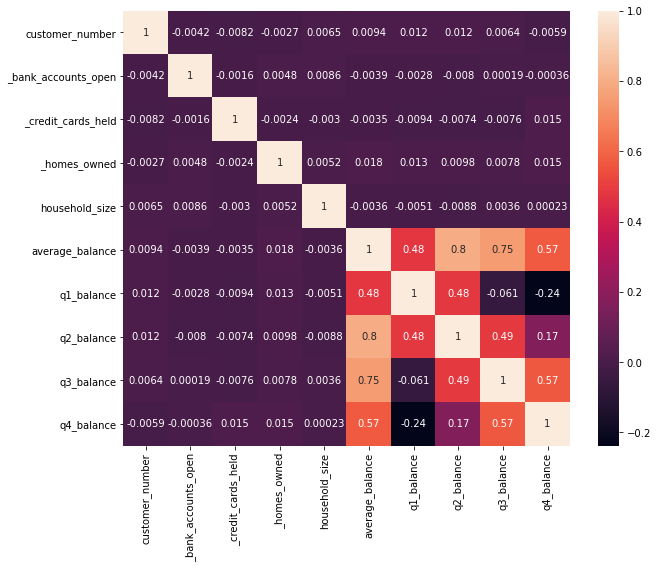

In [15]:
# check the correlations
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [16]:
# As the columns 'average_balance' and 'q1/2/3/4_balance' showed a high correlation they will be dropped
data = data.drop(columns=['q1_balance', 'q2_balance', 'q3_balance', 'q4_balance'])

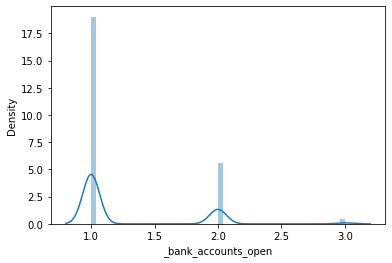

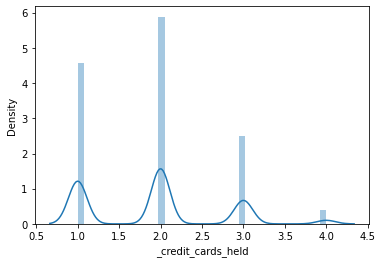

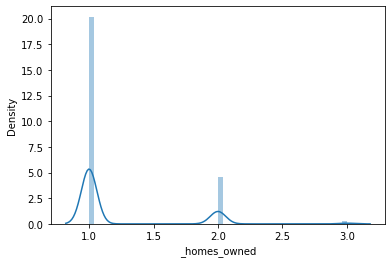

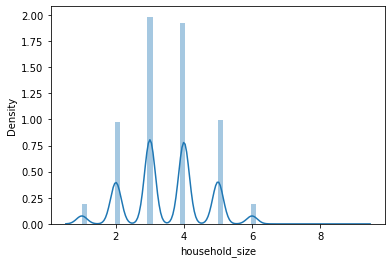

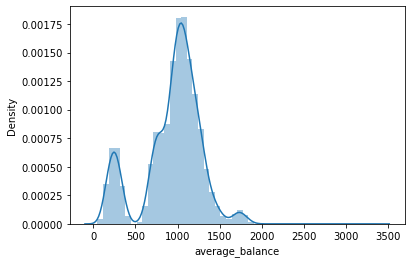

In [17]:
for col in data.select_dtypes(np.number):
    if col == 'customer_number':
        pass
    else:
        sns.distplot(data[col])
        plt.show()

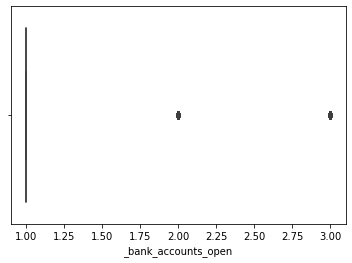

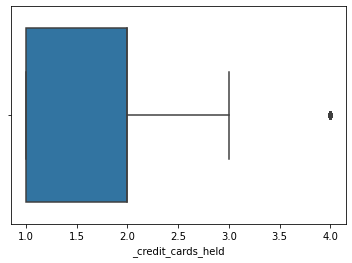

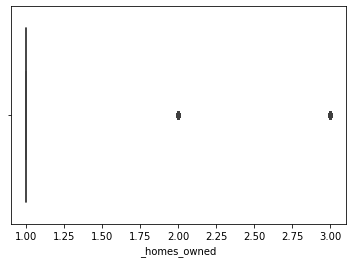

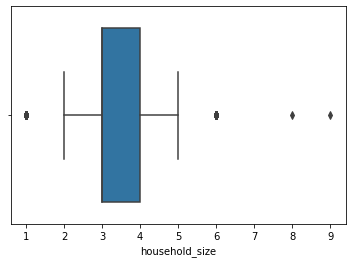

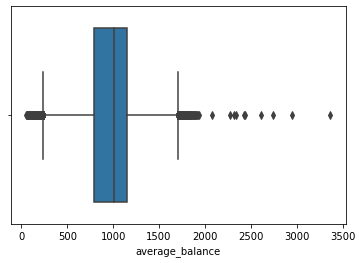

In [18]:
for col in data.select_dtypes(np.number):
    if col == 'customer_number':
        pass
    else:
        sns.boxplot(data[col])
        plt.show()

## 5. Processing Data

- Dealing with outliers.
- Normalization.
- Dealing with imbalanced data.
- Encoding Categorical Data.
- Splitting into train set and test set.

### 5.1. Feature Engineering

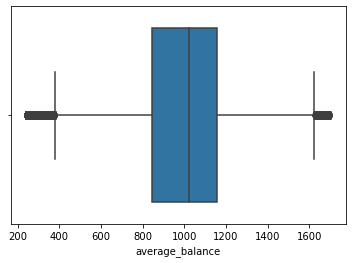

In [19]:
upper = np.percentile(data['average_balance'],75)
lower = np.percentile(data['average_balance'],25)
iqr = upper - lower
upper_limit = upper + (1.5 * iqr)
lower_limit = lower - (1.5 * iqr)
data = data[(data['average_balance']>lower_limit) & (data['average_balance']<upper_limit)]

sns.boxplot(data['average_balance'])
plt.show()

In [20]:
# checking the size of the data loss after removing outliers
data.shape

(16535, 13)

In [21]:
def boxcox_transform(df):
    numeric_cols = df.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        # since i know any columns should take negative numbers, to avoid -inf in df
        df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
        df[column] = df[column].fillna(df[column].mean())
        transformed_data, ci = stats.boxcox(df[column])
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci

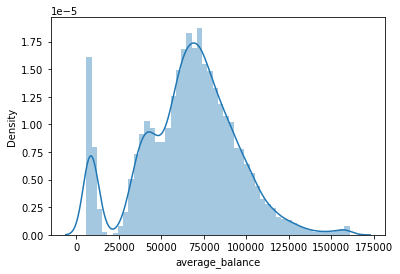

In [22]:
data['average_balance'] = np.where(data['average_balance']<=0, np.NAN, data['average_balance']) 
data['average_balance'] = data['average_balance'].fillna(data['average_balance'].mean())
transformed_data, ci = stats.boxcox(data['average_balance'])
data['average_balance'] = transformed_data
#_ci['average_balance'] = [ci]

sns.distplot(data['average_balance'])
plt.show()

### 5.2. Train the model

#### 5.2.1. Dealing with imbalanced data

In [23]:
y_id = data['offer_accepted']
X_id = data.drop('offer_accepted', axis=1)

In [24]:
#Scaling numerical variables
numericals_id = X_id.select_dtypes(np.number)
transformer_id = StandardScaler().fit(numericals_id)
x_id_standardized = transformer_id.transform(numericals_id)

In [25]:
#Encoding categorical variables
categoricals_id = X_id.select_dtypes(exclude=np.number)
encoder_id = OneHotEncoder(handle_unknown='error', drop='first').fit(categoricals_id)
encoded_id = encoder_id.transform(categoricals_id).toarray()
#X_id = pd.get_dummies(X_id)

In [26]:
X_id = np.concatenate((x_id_standardized, encoded_id), axis=1)

- Upsampling with SMOTE

In [27]:
smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X_id, y_id)
y_sm.value_counts()

No     15601
Yes    15601
Name: offer_accepted, dtype: int64

In [28]:
X_id_train, X_id_test, y_id_train, y_id_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [29]:
classification = LogisticRegression(random_state=42, max_iter=1000)

classification.fit(X_id_train, y_id_train)

LogisticRegression(max_iter=1000, random_state=42)

In [30]:
classification.score(X_id_test, y_id_test)

0.7087005287614164

- Upsampling using weights

In [31]:
total = sum(data['offer_accepted'].value_counts())

weights = {'No': total/data['offer_accepted'].value_counts()['No'],
           'Yes': total/data['offer_accepted'].value_counts()['Yes']}

In [32]:
weights

{'No': 1.0598679571822318, 'Yes': 17.703426124197}

In [33]:
classification = LogisticRegression(random_state=42, class_weight=weights)

In [34]:
data['offer_accepted'].value_counts()

No     15601
Yes      934
Name: offer_accepted, dtype: int64

In [35]:
classification.fit(X_id_train, y_id_train)
classification.score(X_id_test, y_id_test)

0.5370934145169043

- Trying SMOTE again

In [36]:
smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X_id, y_id)
y_sm.value_counts()

No     15601
Yes    15601
Name: offer_accepted, dtype: int64

In [37]:
X_id_train, X_id_test, y_id_train, y_id_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [38]:
classification = LogisticRegression(random_state=42, max_iter=1000)

classification.fit(X_id_train, y_id_train)
classification.score(X_id_test, y_id_test)

0.7101426053517065

#### 5.2.2. KNN

In [39]:
y_knn = data['offer_accepted']
X_knn = data.drop('offer_accepted', axis=1)

In [40]:
#Scaling numerical variables
numericals = X_knn.select_dtypes(np.number)
transformer = StandardScaler().fit(numericals)
x_standardized = transformer.transform(numericals)

In [41]:
#Encoding categorical variables
categoricals = X_knn.select_dtypes(exclude=np.number)
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(categoricals)
encoded = encoder.transform(categoricals).toarray()

In [42]:
X_knn = np.concatenate((x_standardized, encoded), axis=1)
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(X_knn, y_knn, test_size=0.4, random_state=100)

#### Choosing the best value of `k` for the `KNN`

In [43]:
scores = []
for i in range(2,10):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_knn_train, y_knn_train)
    scores.append(model.score(X_knn_test, y_knn_test))

Text(0, 0.5, 'Accuracy')

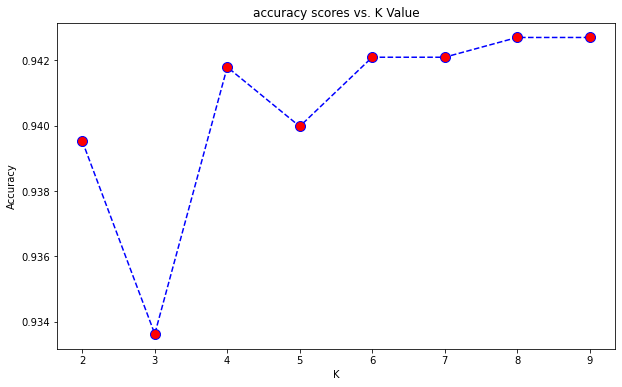

In [44]:
plt.figure(figsize=(10,6))
plt.plot(range(2,10),scores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('accuracy scores vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

In [45]:
#Back to the model
model = KNeighborsClassifier(n_neighbors=4)
#4 instead of 6 bc both numbers give similar results and a smaller number runs faster
model.fit(X_knn_train, y_knn_train)

KNeighborsClassifier(n_neighbors=4)

In [46]:
predictions = model.predict(X_knn_test)
score = model.score(X_knn_test, y_knn_test)

In [47]:
score

0.9417901421227699

### 5.3. Evaluate the model

In [48]:
#Imbalanced data
classification.score(X_id_test, y_id_test)

0.7101426053517065

In [49]:
#KNN
classification.score(X_knn_test, y_knn_test)

0.6970063501663138

In [50]:
# to get predictions id
predictions_id = classification.predict(X_id_test)

In [51]:
# to get predictions knn
predictions_knn = classification.predict(X_knn_test)

In [52]:
confusion_matrix(y_id_test, predictions_id)

array([[2189, 1011],
       [ 798, 2243]], dtype=int64)

In [53]:
confusion_matrix(y_knn_test, predictions_knn)

array([[4349, 1888],
       [ 116,  261]], dtype=int64)

In [54]:
cf_matrix_id = confusion_matrix(y_id_test, predictions_id, normalize='all')

In [55]:
cf_matrix_knn = confusion_matrix(y_knn_test, predictions_knn, normalize='all')

<AxesSubplot:>

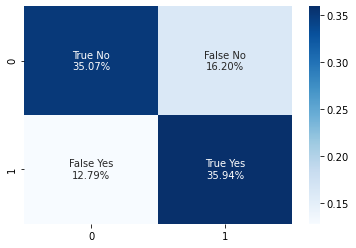

In [56]:
#Confusion matrix Imbalanced Data
group_names_id = ['True No', 'False No', 'False Yes', 'True Yes']
group_counts_id = ["{0:0.2f}".format(value) for value in cf_matrix_id.flatten()]
group_percentages_id = ["{0:.2%}".format(value) for value in cf_matrix_id.flatten()/np.sum(cf_matrix_id)]
labels_id = [f"{v1}\n{v3}" for v1, v3 in zip(group_names_id,group_percentages_id)]
labels_id = np.asarray(labels_id).reshape(2,2)
sns.heatmap(cf_matrix_id, annot=labels_id, fmt='', cmap='Blues')

<AxesSubplot:>

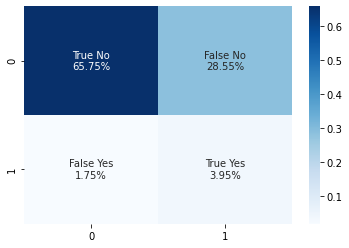

In [57]:
#Confusion matrix KNN
group_names_knn = ['True No', 'False No', 'False Yes', 'True Yes']
group_counts_knn = ["{0:0.2f}".format(value) for value in cf_matrix_knn.flatten()]
group_percentages_knn = ["{0:.2%}".format(value) for value in cf_matrix_knn.flatten()/np.sum(cf_matrix_knn)]
labels_knn = [f"{v1}\n{v3}" for v1, v3 in zip(group_names_knn,group_percentages_knn)]
labels_knn = np.asarray(labels_knn).reshape(2,2)
sns.heatmap(cf_matrix_knn, annot=labels_knn, fmt='', cmap='Blues')

### Logistic Regression Metrics

Concepts:
- Sensitivity: True Positives rate = TP/(TP+FN)
- Specificity: True Negatives rate = TN/(TN+FP)

There are many metrics to aid us on evaluating our model. 
Some famous ones are:
- Accuracy = (TP + TN)/(TP+TN+FP+FN);
- AUC-ROC (Area Under the Curve - Receiver Operating Characteristics);
- F1 score = 2*(precision * recall)/(precision+recall);
- Precision = TP/(TP+FP) - when you rather be sure it is a positive;
- Recall (sensitivity) = TP/(TP+FN) - when we want to get most positives as possible.

More metrics and when to use each: [here](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226).

#### 5.3.1. AUC-ROC

Explains how well separated are the probabilities of the classes. Plots True Positive vs False Positive, and calculates the area under the curve: </br>
Resource to help understand ROC-AUC curve [here](https://www.youtube.com/watch?v=4jRBRDbJemM)

In [58]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

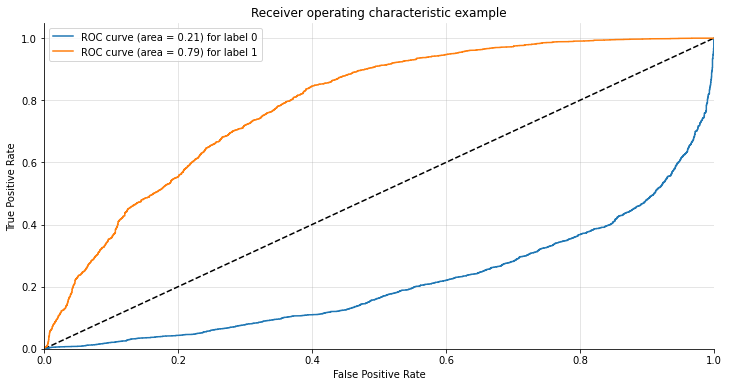

In [59]:
#Imbalanced data
plot_multiclass_roc(classification, X_id_test, y_id_test, n_classes=2, figsize=(12, 6))

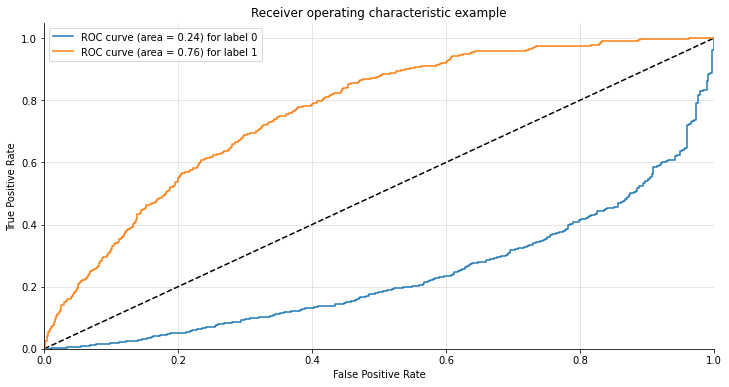

In [60]:
#KNN
plot_multiclass_roc(classification, X_knn_test, y_knn_test, n_classes=2, figsize=(12, 6))

#### 5.3.2. Classification Report

In [61]:
#Imbalanced data
print(metrics.classification_report(y_id_test, predictions_id))

              precision    recall  f1-score   support

          No       0.73      0.68      0.71      3200
         Yes       0.69      0.74      0.71      3041

    accuracy                           0.71      6241
   macro avg       0.71      0.71      0.71      6241
weighted avg       0.71      0.71      0.71      6241



In [62]:
#KNN
print(metrics.classification_report(y_knn_test, predictions_knn))

              precision    recall  f1-score   support

          No       0.97      0.70      0.81      6237
         Yes       0.12      0.69      0.21       377

    accuracy                           0.70      6614
   macro avg       0.55      0.69      0.51      6614
weighted avg       0.93      0.70      0.78      6614



#### Conclusion

- KNN model
Even if the KNN model presents a high precision for 'No' (0.97), the precision for 'Yes' (0.12) is low.
This volatility is also present at the F1-score metric.
Regarding accuracy, the observed levels are lower when comparing to the other model.

- Imbalanced model
By the other hand, the Imbalanced data model shows more consistency presenting precisions of 0.73 and 0.69 for 'No' and 'Yes', recpectively.
This behaviour could also be seen at other metrics as accuracy, recall and F1-score.

- Chosen model
Based on that, the Imbalanced data model has a better fit for the data set.

- Accuracy

Is the proportion of true results among the total number of cases examined.
When to use?
Accuracy is a valid choice of evaluation for classification problems which are well balanced and not skewed or No class imbalance.

- Precision

Is the proportion of predicted Positives is truly Positive.
When to use?
Precision is a valid choice of evaluation metric when we want to be very sure of our prediction.

- Recall

Is the proportion of actual Positives is correctly classified.
When to use?
Recall is a valid choice of evaluation metric when we want to capture as many positives as possible. 

- F1Score

The F1 score is a number between 0 and 1 and is the harmonic mean of precision and recall.
When to use?
We want to have a model with both good precision and recall.

- AUC

AUC is the area under the ROC curve.AUC ROC indicates how well the probabilities from the positive classes are separated from the negative classes.
When to Use?
AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.